In [1]:
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import scikit_posthocs as sp

# Exploration part

In [2]:
# dt_simple = pd.read_csv('./data/clean_products.csv')
dt_grades = pd.read_csv('./data/clean_products_grades_imputed.csv')

colors=["green", "limegreen","gold", "darkorange", "red"]

C:\Users\max\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3172: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Let's capitalize grades
dt_grades['nutrition_grade_fr'] = dt_grades['nutrition_grade_fr'].str.capitalize()

## Data repartition

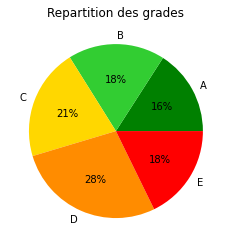

In [4]:
# Plotting nutrition grades
d=dt_grades.groupby('nutrition_grade_fr').size().\
    plot(kind="pie", ylabel='', autopct='%1.0f%%',colors = colors, title='Repartition des grades');
d.get_figure().savefig('./figs/product_grade_prop.png', transparent = True)

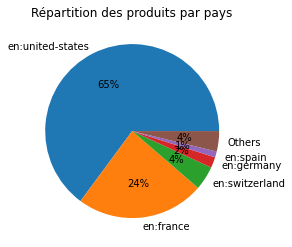

In [5]:
# Countries
dt_tmp = dt_grades.groupby('countries_tags').size().sort_values(ascending=False)

dt_top = pd.DataFrame({'Country' : dt_tmp.index[:5], 'value' : dt_tmp[:5]})
dt_others = pd.DataFrame({'Country' : ['Others'], 'value' : [sum(dt_tmp[5:])]})
dt = pd.concat([dt_top, dt_others])


d=dt.plot(kind='pie', y = 'value', ylabel = '', labels = dt['Country'], autopct='%1.0f%%', legend=False,
       title = "Répartition des produits par pays");
d.get_figure().savefig('./figs/countries_prop.png', dpi=600, transparent = True)

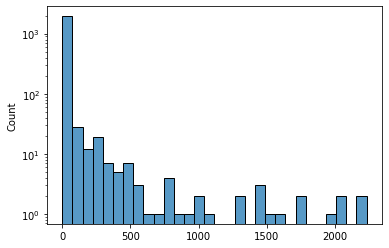

In [6]:
# Categories
dt_tmp = dt_grades.groupby('main_category').size().sort_values(ascending=False)

# sns.histplot(x = (dt_tmp[dt_tmp < 10]), bins = 30);
sns.histplot(x = (dt_tmp), bins = 30, log_scale = [False, True]);

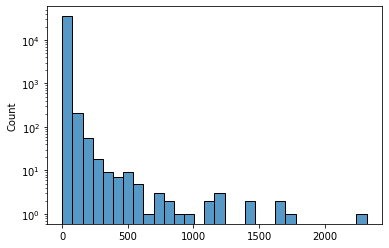

In [7]:
# Brands 
dt_tmp = dt_grades.groupby('brands_tags').size().sort_values(ascending=False)

# sns.histplot(x = (dt_tmp[dt_tmp < 10]), bins = 30);
sns.histplot(x = (dt_tmp), bins = 30, log_scale = [False, True]);

### Plot _100g values ~ nutrition grades + anova

In [8]:
import pingouin as pg 
import scikit_posthocs as sp

def plot_grades_comp(dt_grades, focal_var, focal_var_name):
    sns.set(rc = {'figure.figsize':(15,7)}, font_scale = 2)
    fig, ax = plt.subplots(1,2)

    p=sns.boxplot(y=dt_grades[focal_var], x = dt_grades['nutrition_grade_fr'],
               order = ['A','B','C','D','E'], palette = colors, ax = ax[0])
    p.set_ylabel(focal_var_name)
    p.set_xlabel('Grade')

    p=sns.boxplot(y=np.log(1+dt_grades[focal_var]), x = dt_grades['nutrition_grade_fr'],
               order = ['A','B','C','D','E'], palette = colors, ax = ax[1])
    p.set_ylabel('log(1+{})'.format(focal_var_name))
    p.set_xlabel('Grade')

    fig.savefig('./figs/anova-{}.png'.format(focal_var_name), transparent = True)

def set_anova(dt_grades, focal_var, focal_var_name):

    print('========================== Homoscedasticity ==============================')
    print("==> On natural scale data : ")
    print(pg.homoscedasticity(dt_grades, dv=focal_var, group="nutrition_grade_fr"))

    # With some transformations
    dt_grades_log = dt_grades.copy()
    dt_grades_log[focal_var] = np.log(1+dt_grades_log[focal_var]) 
    print("\n==> On log(1+data) : ")
    print(pg.homoscedasticity(dt_grades_log, dv=focal_var, group="nutrition_grade_fr"))

    dt_grades_sqrt = dt_grades.copy()
    dt_grades_sqrt[focal_var] = np.sqrt(dt_grades_sqrt[focal_var]) 
    print("\n==> On sqrt(data) : ")
    print(pg.homoscedasticity(dt_grades_sqrt, dv=focal_var, group="nutrition_grade_fr"))

    # Better but still not equal variances


    # print('============================================================================')
    # print(dt_grades.anova(dv='sugars_100g', between='nutrition_grade_fr', detailed=True))

    # For group with unequal variances and sizes
    print('============================  ANOVA     ================================')
    print("=> Using Welch Anova")
    print(dt_grades.welch_anova(dv=focal_var, between='nutrition_grade_fr'))

    print("\n=> Using Welch Anova on log(1+x)")
    print(dt_grades_log.welch_anova(dv=focal_var, between='nutrition_grade_fr'))

    # Let's use an non-parametric version
    print("\n=> Using Kruskal (non-parametric ANOVA)")
    print(pg.kruskal(data = dt_grades, dv=focal_var, between='nutrition_grade_fr', detailed = True))


    print('============================   posthoc tests    ================================')
    print("=> Using Pairwise Tukey (assuming normality)") 
    print(dt_grades.pairwise_tukey(dv=focal_var, between='nutrition_grade_fr'))

    print("\n=> Using Pairwise Tukey (assuming normality) on log(1+x)") 
    print(dt_grades_log.pairwise_tukey(dv=focal_var, between='nutrition_grade_fr'))

    # ## Unequela variances
    print("\n=> Using pairwise Gameshowell (assuming normality) on log(1+x)") 
    print(pg.pairwise_gameshowell(dv=focal_var, between='nutrition_grade_fr', data = dt_grades))

    print("\n=> Non-parametric posthoc (conover)") 
    print(sp.posthoc_conover(dt_grades, val_col=focal_var, group_col='nutrition_grade_fr', p_adjust = 'holm'))

In [9]:
dt_grades.columns

Index(['last_modified_datetime', 'created_datetime', 'code', 'countries_tags',
       'product_name', 'brands', 'brands_tags', 'energy_100g', 'proteins_100g',
       'salt_100g', 'ingredients_that_may_be_from_palm_oil_n', 'additives_n',
       'ingredients_from_palm_oil_n', 'sugars_100g', 'fat_100g',
       'carbohydrates_100g', 'saturated-fat_100g', 'nutrition-score-fr_100g',
       'nutrition_grade_fr', 'fiber_100g', 'main_category'],
      dtype='object')

========================== Homoscedasticity ==============================
==> On natural scale data : 
                  W  pval  equal_var
levene  1756.183689   0.0      False

==> On log(1+data) : 
                  W  pval  equal_var
levene  7707.320565   0.0      False

==> On sqrt(data) : 
                  W  pval  equal_var
levene  3079.768098   0.0      False
============================  ANOVA     ================================
=> Using Welch Anova
               Source  ddof1          ddof2             F  p-unc       np2
0  nutrition_grade_fr      4  103613.138115  43354.582236    0.0  0.421098

=> Using Welch Anova on log(1+x)
               Source  ddof1         ddof2            F  p-unc       np2
0  nutrition_grade_fr      4  95888.326685  23476.90723    0.0  0.278143

=> Using Kruskal (non-parametric ANOVA)
                     Source  ddof1             H  p-unc
Kruskal  nutrition_grade_fr      4  94366.729638    0.0
============================   posthoc tests    ====

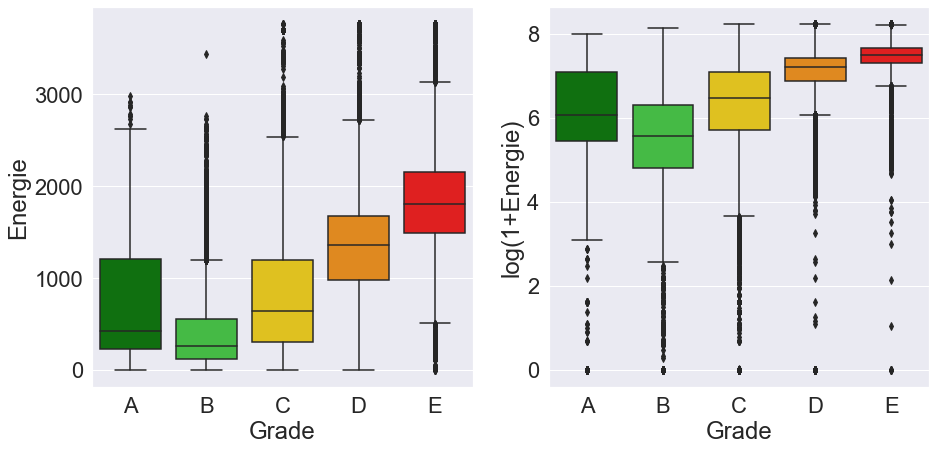

In [10]:
# Energy
set_anova(dt_grades= dt_grades, focal_var = 'energy_100g', focal_var_name = 'Energie')
plot_grades_comp(dt_grades= dt_grades, focal_var = 'energy_100g', focal_var_name = 'Energie')

========================== Homoscedasticity ==============================
==> On natural scale data : 
                  W  pval  equal_var
levene  1508.028229   0.0      False

==> On log(1+data) : 
                 W  pval  equal_var
levene  1410.26648   0.0      False

==> On sqrt(data) : 
                  W  pval  equal_var
levene  1242.895523   0.0      False
============================  ANOVA     ================================
=> Using Welch Anova
               Source  ddof1          ddof2            F  p-unc       np2
0  nutrition_grade_fr      4  104638.328303  3076.972503    0.0  0.045777

=> Using Welch Anova on log(1+x)
               Source  ddof1          ddof2           F  p-unc       np2
0  nutrition_grade_fr      4  105165.556851  4470.37979    0.0  0.064927

=> Using Kruskal (non-parametric ANOVA)
                     Source  ddof1            H  p-unc
Kruskal  nutrition_grade_fr      4  13519.31055    0.0
============================   posthoc tests    ==========

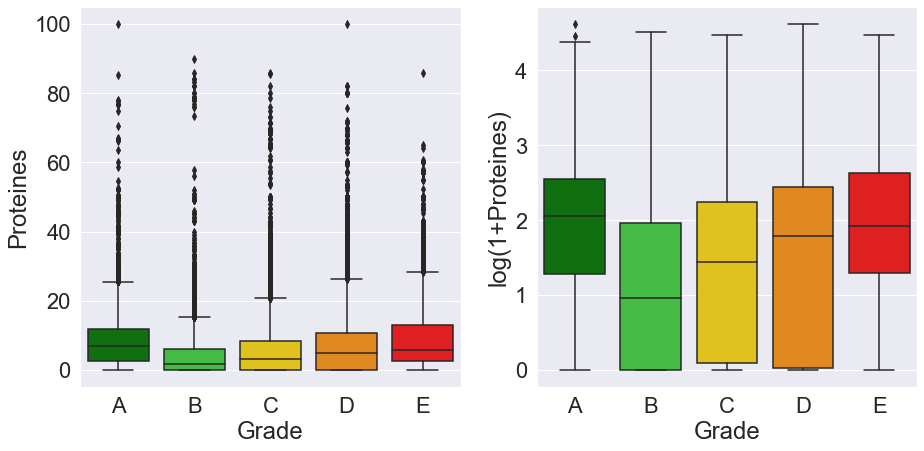

In [11]:
# Proteins
set_anova(dt_grades= dt_grades, focal_var = 'proteins_100g', focal_var_name = 'Proteines')
plot_grades_comp(dt_grades= dt_grades, focal_var = 'proteins_100g', focal_var_name = 'Proteines')

========================== Homoscedasticity ==============================
==> On natural scale data : 
                  W  pval  equal_var
levene  1396.468968   0.0      False

==> On log(1+data) : 
                  W  pval  equal_var
levene  4442.380973   0.0      False

==> On sqrt(data) : 
                  W  pval  equal_var
levene  2100.483524   0.0      False
============================  ANOVA     ================================
=> Using Welch Anova
               Source  ddof1          ddof2            F  p-unc       np2
0  nutrition_grade_fr      4  101997.275043  3927.771328    0.0  0.028106

=> Using Welch Anova on log(1+x)
               Source  ddof1          ddof2             F  p-unc       np2
0  nutrition_grade_fr      4  106219.544667  11051.093965    0.0  0.105993

=> Using Kruskal (non-parametric ANOVA)
                     Source  ddof1             H  p-unc
Kruskal  nutrition_grade_fr      4  27111.903824    0.0
============================   posthoc tests    ==

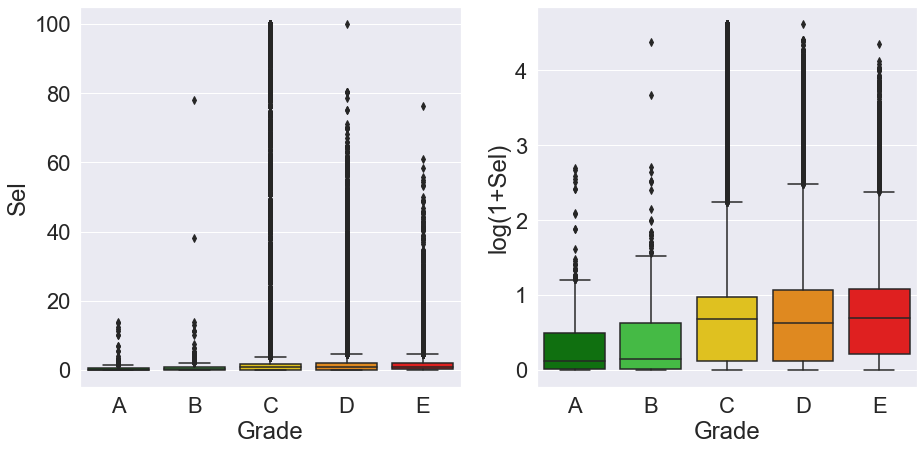

In [12]:
# Salt
set_anova(dt_grades= dt_grades, focal_var = 'salt_100g', focal_var_name = 'Sel')
plot_grades_comp(dt_grades= dt_grades, focal_var = 'salt_100g', focal_var_name = 'Sel')

========================== Homoscedasticity ==============================
==> On natural scale data : 
                   W  pval  equal_var
levene  20674.190942   0.0      False

==> On log(1+data) : 
                  W  pval  equal_var
levene  6758.223358   0.0      False

==> On sqrt(data) : 
                   W  pval  equal_var
levene  18714.421526   0.0      False
============================  ANOVA     ================================
=> Using Welch Anova
               Source  ddof1          ddof2             F  p-unc       np2
0  nutrition_grade_fr      4  103798.720672  17485.257923    0.0  0.189667

=> Using Welch Anova on log(1+x)
               Source  ddof1          ddof2             F  p-unc       np2
0  nutrition_grade_fr      4  105869.018909  10131.700966    0.0  0.133915

=> Using Kruskal (non-parametric ANOVA)
                     Source  ddof1             H  p-unc
Kruskal  nutrition_grade_fr      4  26548.227661    0.0
============================   posthoc tests

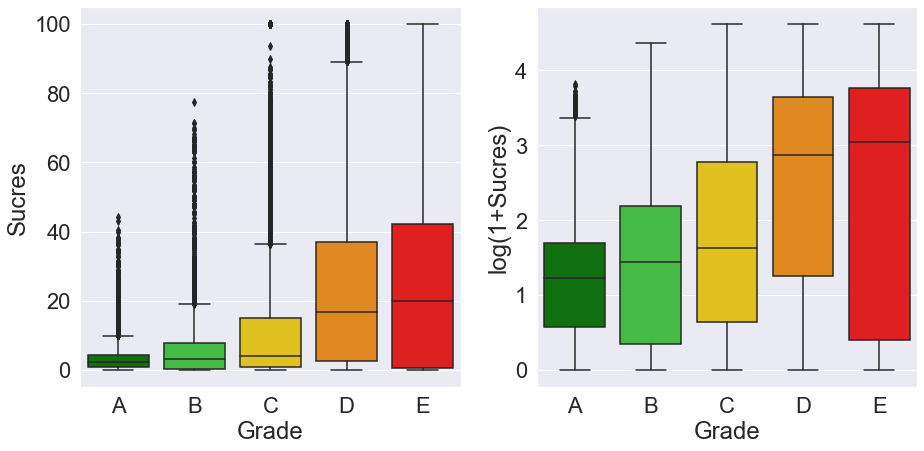

In [13]:
# Sugars
set_anova(dt_grades= dt_grades, focal_var = 'sugars_100g', focal_var_name = 'Sucres')
plot_grades_comp(dt_grades= dt_grades, focal_var = 'sugars_100g', focal_var_name = 'Sucres')

========================== Homoscedasticity ==============================
==> On natural scale data : 
                  W  pval  equal_var
levene  5674.031952   0.0      False

==> On log(1+data) : 
                 W  pval  equal_var
levene  792.840297   0.0      False

==> On sqrt(data) : 
                  W  pval  equal_var
levene  2294.437991   0.0      False
============================  ANOVA     ================================
=> Using Welch Anova
               Source  ddof1          ddof2            F  p-unc       np2
0  nutrition_grade_fr      4  104283.719871  7767.557942    0.0  0.101215

=> Using Welch Anova on log(1+x)
               Source  ddof1          ddof2            F  p-unc       np2
0  nutrition_grade_fr      4  103371.449552  4156.526169    0.0  0.064717

=> Using Kruskal (non-parametric ANOVA)
                     Source  ddof1             H  p-unc
Kruskal  nutrition_grade_fr      4  18045.118091    0.0
============================   posthoc tests    ======

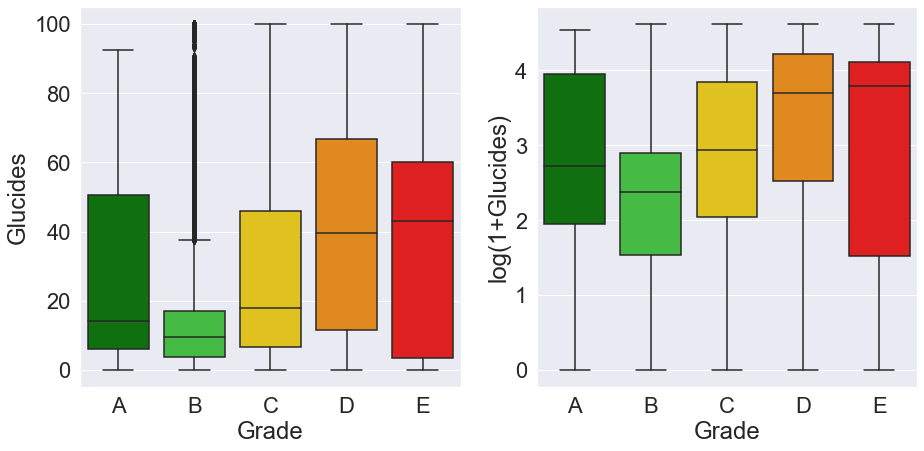

In [14]:
# Glucides
set_anova(dt_grades= dt_grades, focal_var = 'carbohydrates_100g', focal_var_name = 'Glucides')
plot_grades_comp(dt_grades= dt_grades, focal_var = 'carbohydrates_100g', focal_var_name = 'Glucides')

========================== Homoscedasticity ==============================
==> On natural scale data : 
                  W  pval  equal_var
levene  9599.490209   0.0      False

==> On log(1+data) : 
                  W  pval  equal_var
levene  4418.607855   0.0      False

==> On sqrt(data) : 
                  W  pval  equal_var
levene  5777.046815   0.0      False
============================  ANOVA     ================================
=> Using Welch Anova
               Source  ddof1          ddof2             F  p-unc       np2
0  nutrition_grade_fr      4  105015.672255  22754.032971    0.0  0.326031

=> Using Welch Anova on log(1+x)
               Source  ddof1          ddof2             F  p-unc       np2
0  nutrition_grade_fr      4  106716.087796  34128.469389    0.0  0.330514

=> Using Kruskal (non-parametric ANOVA)
                     Source  ddof1             H  p-unc
Kruskal  nutrition_grade_fr      4  71368.645518    0.0
============================   posthoc tests    

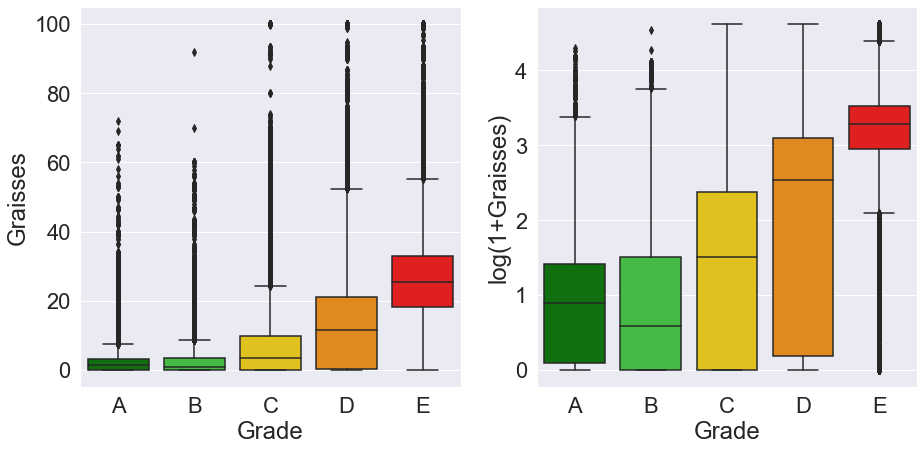

In [15]:
# Fat
set_anova(dt_grades= dt_grades, focal_var = 'fat_100g', focal_var_name = 'Graisses')
plot_grades_comp(dt_grades= dt_grades, focal_var = 'fat_100g', focal_var_name = 'Graisses')

========================== Homoscedasticity ==============================
==> On natural scale data : 
                   W  pval  equal_var
levene  13808.238762   0.0      False

==> On log(1+data) : 
                   W  pval  equal_var
levene  11375.786282   0.0      False

==> On sqrt(data) : 
                  W  pval  equal_var
levene  9796.430467   0.0      False
============================  ANOVA     ================================
=> Using Welch Anova
               Source  ddof1          ddof2             F  p-unc       np2
0  nutrition_grade_fr      4  103013.266142  25475.207483    0.0  0.403136

=> Using Welch Anova on log(1+x)
               Source  ddof1          ddof2             F  p-unc       np2
0  nutrition_grade_fr      4  106557.256711  55706.078737    0.0  0.469137

=> Using Kruskal (non-parametric ANOVA)
                     Source  ddof1             H  p-unc
Kruskal  nutrition_grade_fr      4  84058.524704    0.0
============================   posthoc tests

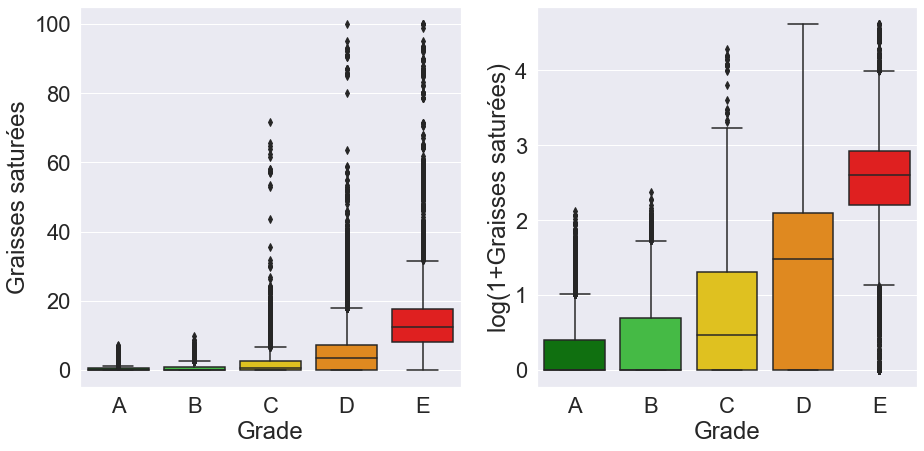

In [16]:
# Sat. Fat
set_anova(dt_grades= dt_grades, focal_var = 'saturated-fat_100g', focal_var_name = 'Graisses saturées')
plot_grades_comp(dt_grades= dt_grades, focal_var = 'saturated-fat_100g', focal_var_name = 'Graisses saturées')

========================== Homoscedasticity ==============================
==> On natural scale data : 
                  W  pval  equal_var
levene  1295.568814   0.0      False

==> On log(1+data) : 
                 W  pval  equal_var
levene  496.134829   0.0      False

==> On sqrt(data) : 
                 W           pval  equal_var
levene  287.475153  5.187044e-247      False
============================  ANOVA     ================================
=> Using Welch Anova
               Source  ddof1          ddof2            F  p-unc       np2
0  nutrition_grade_fr      4  105841.137373  3415.208556    0.0  0.044583

=> Using Welch Anova on log(1+x)
               Source  ddof1         ddof2            F  p-unc       np2
0  nutrition_grade_fr      4  104527.89697  4122.883527    0.0  0.062351

=> Using Kruskal (non-parametric ANOVA)
                     Source  ddof1            H  p-unc
Kruskal  nutrition_grade_fr      4  13970.29144    0.0
============================   posthoc tes

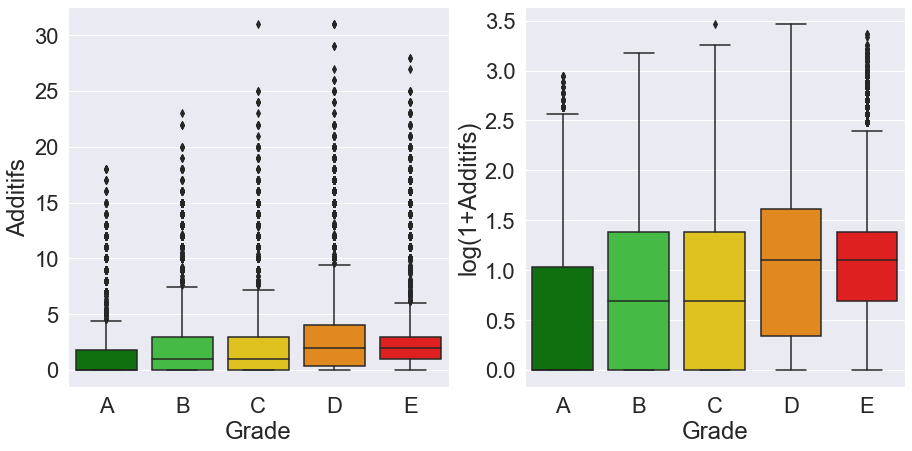

In [17]:
# Additives_n
set_anova(dt_grades= dt_grades, focal_var = 'additives_n', focal_var_name = 'Additifs')
plot_grades_comp(dt_grades= dt_grades, focal_var = 'additives_n', focal_var_name = 'Additifs')

========================== Homoscedasticity ==============================
==> On natural scale data : 
                 W  pval  equal_var
levene  2303.26836   0.0      False

==> On log(1+data) : 
                  W  pval  equal_var
levene  1724.312812   0.0      False

==> On sqrt(data) : 
                  W  pval  equal_var
levene  1712.184375   0.0      False
============================  ANOVA     ================================
=> Using Welch Anova
               Source  ddof1          ddof2            F  p-unc       np2
0  nutrition_grade_fr      4  102240.242085  3551.072354    0.0  0.088236

=> Using Welch Anova on log(1+x)
               Source  ddof1          ddof2            F  p-unc       np2
0  nutrition_grade_fr      4  103977.854811  7967.400603    0.0  0.130463

=> Using Kruskal (non-parametric ANOVA)
                     Source  ddof1             H  p-unc
Kruskal  nutrition_grade_fr      4  29025.144295    0.0
============================   posthoc tests    ======

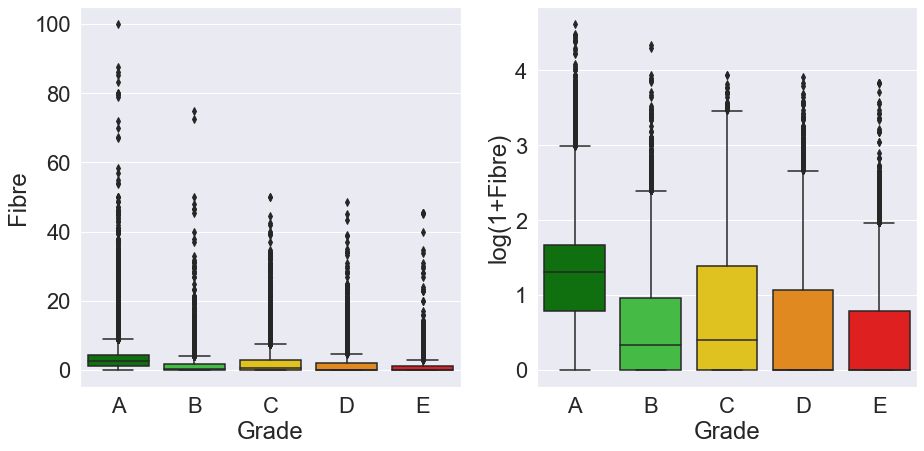

In [18]:
# Fiber
set_anova(dt_grades= dt_grades, focal_var = 'fiber_100g', focal_var_name = 'Fibre')
plot_grades_comp(dt_grades= dt_grades, focal_var = 'fiber_100g', focal_var_name = 'Fibre')

========================== Homoscedasticity ==============================
==> On natural scale data : 
                 W  pval  equal_var
levene  801.096487   0.0      False

==> On log(1+data) : 
                 W  pval  equal_var
levene  834.178882   0.0      False

==> On sqrt(data) : 
                 W  pval  equal_var
levene  884.493385   0.0      False
============================  ANOVA     ================================
=> Using Welch Anova
               Source  ddof1          ddof2           F  p-unc       np2
0  nutrition_grade_fr      4  104393.079335  852.693484    0.0  0.014449

=> Using Welch Anova on log(1+x)
               Source  ddof1          ddof2           F  p-unc       np2
0  nutrition_grade_fr      4  104272.477481  887.130882    0.0  0.015037

=> Using Kruskal (non-parametric ANOVA)
                     Source  ddof1            H  p-unc
Kruskal  nutrition_grade_fr      4  3684.136791    0.0
============================   posthoc tests    ================

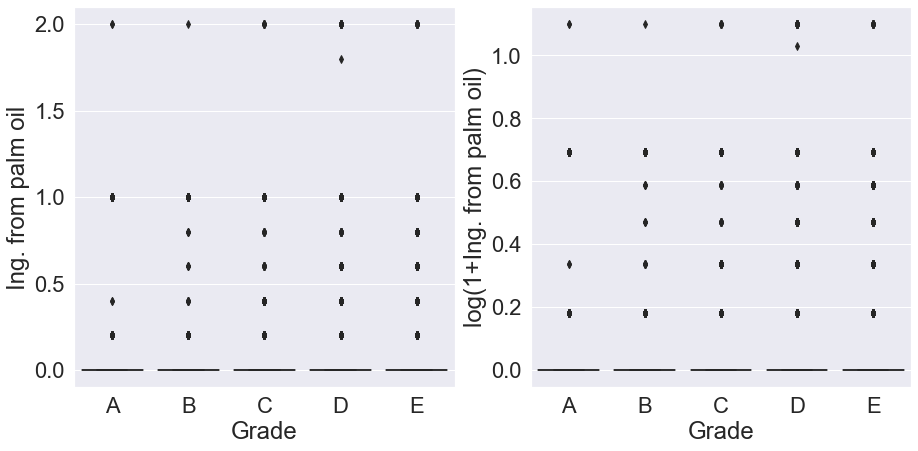

In [19]:
# Palm
set_anova(dt_grades= dt_grades, focal_var = 'ingredients_from_palm_oil_n', focal_var_name = 'Ing. from palm oil')
plot_grades_comp(dt_grades= dt_grades, focal_var = 'ingredients_from_palm_oil_n', focal_var_name = 'Ing. from palm oil')

Bref ! 
Lot of data, heteroscedasticity, residuals are non normal; not sure ANOVA is really appropriate here. 

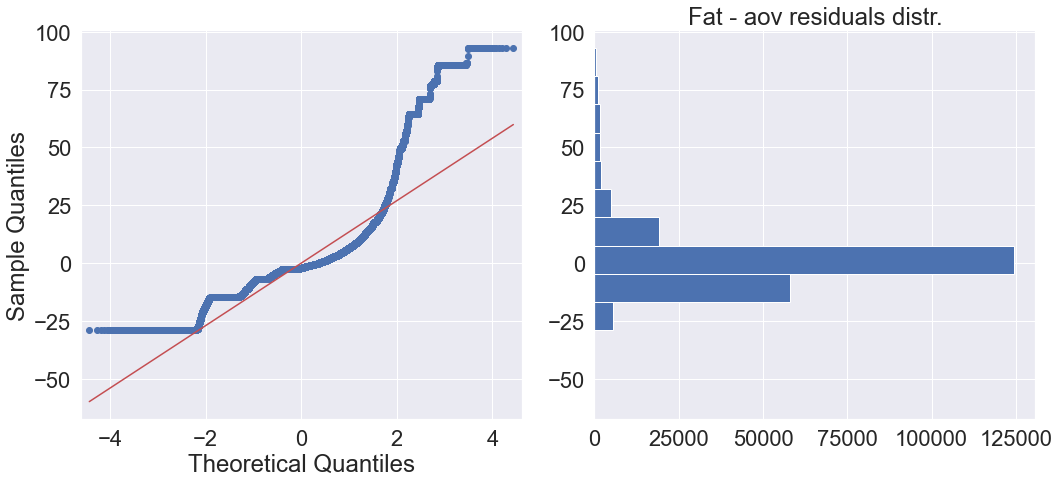

In [20]:
# Residuals check for one case (Fat; which present one n.s. difference in posthoc tests)

from statsmodels.formula.api import ols
import statsmodels.api as sm
from matplotlib import pyplot

model = ols('fat_100g ~ C(nutrition_grade_fr)', data = dt_grades).fit()
# pyplot.hist(model.resid)

sns.set(rc = {'figure.figsize':(15,7)}, font_scale = 2)
fig, ax = plt.subplots(1,2)
p = sm.qqplot(model.resid,  line='s',ax = ax[0])
p = pyplot.hist(model.resid, orientation='horizontal')
plt.ylim(ax[0].get_ylim())

plt.tight_layout()
plt.title("Fat - aov residuals distr.")
fig.savefig('./figs/fat_qqplot.png')

# PCA approache

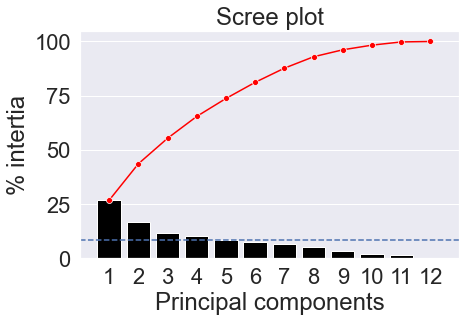

In [21]:
import re
from sklearn import decomposition
from sklearn import preprocessing

c = [x for x in dt_grades.columns if '100g' in x]
[c.append(x) for x in dt_grades.columns if re.match('.*_n$', x)]
# c.remove('nutrition-score-fr_100g')

# Standartization
dt_grades_scaled = dt_grades.copy()
dt_grades_scaled.loc[:,c] = preprocessing.StandardScaler().fit_transform(dt_grades.loc[:,c])
pca = decomposition.PCA(n_components = len(c))
pca.fit_transform(dt_grades_scaled.loc[:,c])

# Explained intertia %
ev=pca.explained_variance_ratio_*100

sns.set(rc = {'figure.figsize':(7,5)}, font_scale = 2)

p=sns.barplot(x=np.arange(len(ev))+1, y=ev, color = 'black');
p=sns.lineplot(x=np.arange(len(ev)), y = ev.cumsum(), marker = 'o', color = 'red')
plt.axhline(y=100/len(c), color='b', linestyle='--')
p.set_ylabel('% intertia');
p.set_xlabel('Principal components');
plt.title('Scree plot');
plt.tight_layout()
p.get_figure().savefig('./figs/screeplot.png')

In [22]:
# Function display_corr_circle()

def display_corr_circle(pcs, ev, axis, labels, dist_threshold = 0.4, jitter = 0.08):
    d1 = axis[0]-1
    d2 = axis[1]-1
    fig, ax = plt.subplots(figsize=(7,6))

    # Could also implement cos2 quality.
    distance_subset = np.apply_along_axis(lambda x : np.sqrt(np.sum(x**2)), 1, pcs[[d1, d2],:].T) > dist_threshold
    
    # Draw arrows
    plt.quiver(np.zeros(sum(distance_subset)), np.zeros(sum(distance_subset)),
                       pcs[d1,distance_subset], pcs[d2,distance_subset], 
                       angles='xy', scale_units='xy', scale=1, color="grey")
    plt.xlim([-1.01,1.01])
    plt.ylim([-1.01,1.01])

    # Labels
    # Jittering randomly, may need several draw to get something w/o overlapping labels
    for i,(x, y) in enumerate(pcs[[d1, d2]].T):
        if distance_subset[i]:
            plt.text(x, (y + np.random.uniform(-jitter,+jitter,1)),
                     labels[i], fontsize='18', ha='left', va='center', color = 'black', alpha=0.5)

    # Circle
    circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='black')
    plt.gca().add_artist(circle)

    plt.xlabel('PC{} ({}%)'.format(axis[0], round(100*pca.explained_variance_ratio_[d1],1)))
    plt.ylabel('PC{} ({}%)'.format(axis[1], round(100*pca.explained_variance_ratio_[d2],1)))

    plt.title("Cercle des corrélations (PC{} et PC{})".format(d1+1, d2+1));

## Corr. circles

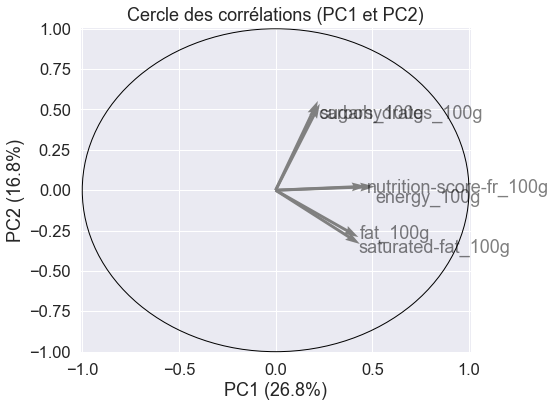

In [23]:
pcs = pca.components_

sns.set(rc = {'figure.figsize':(7,5)}, font_scale = 1.5)
display_corr_circle(pcs, ev, (1,2), labels = np.array(c))

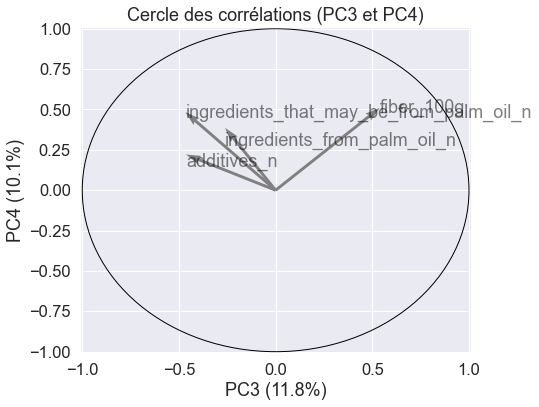

In [24]:
display_corr_circle(pcs, ev, (3,4), labels = np.array(c))

# Note : axis 3 is reversed in pptx for presentation purpose

Approximatively:
+ F1 : fat/saturated-fat and energy
+ F2 : sugar and carbohydrates
+ F3 : oppose fiber <-> ing. from palm oil / additives
+ F4 : more fiber and/or palm oil / additives

## Ind. in PCA plane

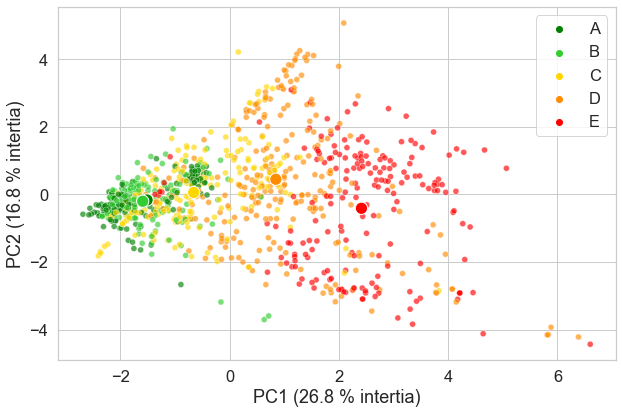

In [25]:
X_proj = pca.transform(dt_grades_scaled.loc[:,c])

# Compute centroids
centroids = pd.DataFrame(X_proj)
centroids.insert(loc = 0, column = "nutrition_grade_fr", value = (dt_grades_scaled['nutrition_grade_fr']))
centroids = centroids.groupby('nutrition_grade_fr').agg(lambda x : np.mean(x))

# Reduce full data set to reduce points overlap
dt_red = dt_grades_scaled.sample(1000)

# Idv. projection 
X_proj_red = pca.transform(dt_red.loc[:,c])

# Plot
axis = [0, 1]
sns.set(rc = {'figure.figsize':(10,6.5)}, font_scale = 1.5)
sns.set_style("whitegrid")
# Idv
p = sns.scatterplot(x=list(X_proj_red[:,axis[0]]), y=list(X_proj_red[:,axis[1]]), alpha = 0.65,
                hue = dt_red['nutrition_grade_fr'],
                hue_order = ['A','B','C','D','E'], palette = colors)

# Add centroids
p = sns.scatterplot(x = list(centroids.iloc[:,axis[0]]), y = list(centroids.iloc[:,axis[1]]), s = 150,
               hue = centroids.index, hue_order = ['A','B','C','D','E'], palette = colors, legend = False)

plt.legend(title='')
p.set_xlabel('PC{:.0f} ({:.1f} % intertia)'.format(axis[0]+1, ev[axis[0]]));
p.set_ylabel('PC{:.0f} ({:.1f} % intertia)'.format(axis[1]+1, ev[axis[1]]));

p.get_figure().savefig('./figs/pca_PC1_PC2.png')



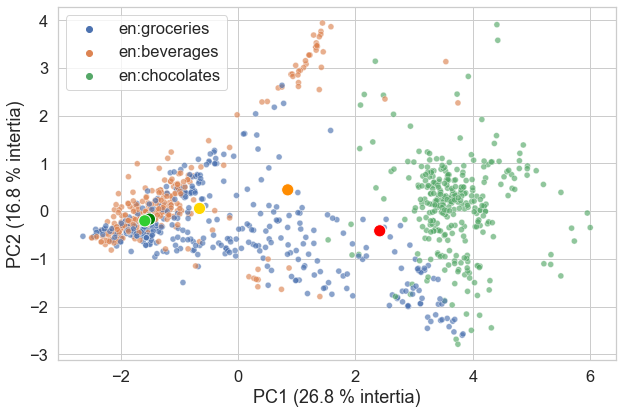

In [26]:
# Plotting most common categories

sub = list(dt_grades_scaled.groupby('main_category')['code'].count().sort_values(ascending=False)[0:3].index)

dt_red = dt_grades_scaled[dt_grades_scaled['main_category'].isin(sub)].sample(1000)

# Idv. projection 
X_proj_red = pca.transform(dt_red.loc[:,c])

# Plot
axis = [0, 1]
sns.set(rc = {'figure.figsize':(10,6.5)}, font_scale = 1.5)
sns.set_style("whitegrid")
# Idv
p = sns.scatterplot(x=list(X_proj_red[:,axis[0]]), y=list(X_proj_red[:,axis[1]]), 
                    alpha = 0.65, hue = dt_red['main_category'])

# Add centroids
p = sns.scatterplot(x = list(centroids.iloc[:,axis[0]]), y = list(centroids.iloc[:,axis[1]]), s = 150,
               hue = centroids.index, hue_order = ['A','B','C','D','E'], palette = colors, legend = False)

plt.legend(title='')
p.set_xlabel('PC{:.0f} ({:.1f} % intertia)'.format(axis[0]+1, ev[axis[0]]));
p.set_ylabel('PC{:.0f} ({:.1f} % intertia)'.format(axis[1]+1, ev[axis[1]]));

p.get_figure().savefig('./figs/pca_PC1_PC2_main-cat.png')

# Alternative approach (Linear Discriminant Analysis)

## Data preparation

In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

c = [x for x in dt_grades.columns if '100g' in x]
[c.append(x) for x in dt_grades.columns if re.match('.*_n$', x)]
c.remove('nutrition-score-fr_100g')

# Standartization
dt_grades_scaled = dt_grades.copy()

# LDA assume multivariate normality... let's log(1+x) data to make data a bit closer (excluding nutrition-score)
# dt_grades_scaled.loc[:,c] = dt_grades_scaled.loc[:,c].apply(lambda x : np.log(1+x), axis = 1)

# Add nutrition score to c for scaling
c = [x for x in dt_grades.columns if '100g' in x]
[c.append(x) for x in dt_grades.columns if re.match('.*_n$', x)]
dt_grades_scaled.loc[:,c] = preprocessing.StandardScaler().fit_transform(dt_grades.loc[:,c])

## Train LDA

In [28]:
from sklearn.model_selection import train_test_split

lda = LDA()

X = dt_grades_scaled[c]
Y = dt_grades_scaled['nutrition_grade_fr']

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, train_size = .9)

lda.fit(xtrain, ytrain);
print(lda.score(xtrain, ytrain))
print(lda.score(xtest, ytest))

ev = lda.explained_variance_ratio_*100
scaling = lda.scalings_
class_means = lda.means_

0.8577361828459881
0.8601820926934163


In [ ]:
X_proj = lda.transform(X)

# Compute centroids
centroids = pd.DataFrame(X_proj)
centroids.insert(loc = 0, column = "nutrition_grade_fr", value = Y)
centroids = centroids.groupby('nutrition_grade_fr').agg(lambda x : np.mean(x))

# Reduce full data set to reduce points overlap
dt_grades_scaled_red = dt_grades_scaled.sample(2500)

X_red = dt_grades_scaled_red[c]
Y_red = dt_grades_scaled_red['nutrition_grade_fr']

# Idv. projection 
X_proj_red = lda.transform(X_red)

# Plot
axis = [0, 1]
sns.set(rc = {'figure.figsize':(10,6.5)}, font_scale = 1.5)
sns.set_style("whitegrid")

# Idv (/!\ axis can be reversed - might use (*-1) for presentation purpose)
p = sns.scatterplot(x=list(X_proj_red[:,axis[0]]), y=list(-X_proj_red[:,axis[1]]), alpha = 0.65,
                hue = Y_red,
                hue_order = ['A','B','C','D','E'], palette = colors)

# Add centroids (/!\ axis can be reversed - might use (*-1) for presentation purpose)
p = sns.scatterplot(x = list(centroids.iloc[:,axis[0]]), y = list(-centroids.iloc[:,axis[1]]), s = 150,
               hue = centroids.index, hue_order = ['A','B','C','D','E'], palette = colors, legend = False)

plt.legend(title='')
p.set_xlabel('LD{:.0f} ({:.1f} %)'.format(axis[0]+1, ev[axis[0]]));
p.set_ylabel('LD{:.0f} ({:.1f} %)'.format(axis[1]+1, ev[axis[1]]));

lims = (p.get_xlim(), p.get_ylim()) # Used later

p.get_figure().savefig('./figs/lda_PC1_PC2.png')

## App. idea : classifying brands for given category

Idea stands on that fact that we cannot compute a mean Nutriscore Grade for a brand - BUT an average product for a brand can be project into that LD plane.

### e.g., which brand to choose for a chocolated product ?

In [ ]:
# Get all beverages products, and compute average characteristics by brand
search_cat = 'en:beverages'

brands_avg = dt_grades_scaled[dt_grades_scaled['main_category'] == search_cat][ [*c, 'brands_tags'] ].\
                groupby('brands_tags').\
                agg(lambda x : np.mean(x))

# Number of product by brands
brands_nproduct = dt_grades_scaled[dt_grades_scaled['main_category'] == search_cat].\
                    groupby('brands_tags').\
                    size()

# Brands must have at least 10 product to be consider
brands_avg = brands_avg[brands_nproduct >= 10]

brands_proj = lda.transform(brands_avg)

# Plot
axis = [0, 1]
sns.set(rc = {'figure.figsize':(10,6.5)}, font_scale = 1.5)
sns.set_style("whitegrid")

# Idv (/!\ axis can be reversed - might use (*-1) for presentation purpose)
p = sns.scatterplot(x=list(brands_proj[:,axis[0]]), y=list(-brands_proj[:,axis[1]]), alpha = 0.65)

# Add centroids (/!\ axis can be reversed - might use (*-1) for presentation purpose)
p = sns.scatterplot(x = list(centroids.iloc[:,axis[0]]), y = list(-centroids.iloc[:,axis[1]]), s = 150,
               hue = centroids.index, hue_order = ['A','B','C','D','E'], palette = colors, legend = False)

# plt.legend(title='')
p.set_xlabel('LD{:.0f} ({:.1f} %)'.format(axis[0]+1, ev[axis[0]]));
p.set_ylabel('LD{:.0f} ({:.1f} %)'.format(axis[1]+1, ev[axis[1]]));

p.set_xlim(lims[0]);
p.set_ylim(lims[1]);

p.get_figure().savefig('./figs/lda_beverages.png');

Nutrition Grade discrimination is excellent along axis 1 : then axis 1 represents a ranking. (more complexe measure could be considered : e.g., euclidean distance to centroids - but useless knowing discrimination is almost 98% on LD1)

In [ ]:
# Best brands for beverages will be :

# /!\ if re-run axes orientation might change (doesn't change ordination but only orientation) and then, ranking might be reversed

brands_ranks = brands_proj[:,0]

pd.DataFrame({'brands' : brands_avg.index,
              'rank' : brands_ranks}).sort_values(by=['rank'], ascending=False) # Again, reversed order compare to plot

In [ ]:
dt_grades_scaled[ (dt_grades_scaled['main_category'] == 'en:beverages') &\
                  (dt_grades_scaled['brands_tags'] == 'nescafe,nestle')]